Title: March Madness
Date: 2019-04-18 12:00
Topic: EDA, Modeling and Evaluation
Slug: ncaa

How likely is a team to make the Final Four of the NCAA Tournament?

# Introduction

Each year, close to $4 billion is wagered on the NCAA Division 1 men's basketball tournament. Most of that money is wagered where the objective is to correctly predict winners of each game, with emphasis on the last four teams remaining (the Final Four). 

In this project, my motivation is the following:

> Based on a college's regular season performance and seeding information, can I predict whether or not they will reach the final four? 
<br>
<br>

What are the variables that are correlated to predicting teams that make it to the final four? As a corollary, my model will also output the associated probabilities of making it to the final 4. Am I able to outperform a naive model? As even the sport pundits will tell you, since 2008, 53% of the time, at least 2 No. 1 seeds make the final four. So just by choosing two No 1. seeds, you're half way there.


As a trusted advisor to Coach Krzyzewski (Duke) or Coach Izzo (Michigan State), how would I recommend spending time developing the team? 

Or at the very least, how do I improve my 2020 bracket to make some money?

---

# Preprocessing

## Import libraries

In [7]:
# data wrangling
import pandas as pd
import numpy as np

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import HTML

# preprocessing & feature engineering
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn_pandas import DataFrameMapper, CategoricalImputer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

# modelling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix

# scientific notation off
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

# suppress warnings
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore')

---
## Data

The data spans 2003 to 2017 and is compiled from [sports-reference.com](https://www.sports-reference.com/cbb/schools/virginia/2019-gamelogs.html). 

The data is spread across four files:

- `regular_season.csv` - gamelogs for every regular season game
- `teams.csv` - team_id, names, and conferences
- `march_madness.csv` - gamelogs for each NCAA tournament game
- `march_madness_seeds.csv` - entry seeds for each team (W, X, Y, Z indicate the region)

In [9]:
pwd

'/Users/gc/portfolio/2_march_madness'

### Understand the data

In [10]:
regular = pd.read_csv("./data/regular_season.csv")
HTML(regular.tail(3).to_html(classes="table table-responsive table-striped table-bordered"))

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score,winning_team_field_goals,winning_team_field_goals_attempted,winning_team_three_points,winning_team_three_points_attempted,winning_team_free_throws,winning_team_free_throws_attempted,winning_team_offensive_rebounds,winning_team_defensive_rebounds,winning_team_assists,winning_team_turnovers,winning_team_steals,winning_team_blocks,winning_team_personal_fouls,losing_team_field_goals,losing_team_field_goals_attempted,losing_team_three_points,losing_team_three_points_attempted,losing_team_free_throws,losing_team_free_throws_attempted,losing_team_offensive_rebounds,losing_team_defensive_rebounds,losing_team_assists,losing_team_turnovers,losing_team_steals,losing_team_blocks,losing_team_personal_fouls
76633,2017,132,1348,70,1433,63,24,54,8,20,14,19,9,27,12,6,3,7,18,21,67,4,14,17,22,23,24,8,5,4,1,16
76634,2017,132,1374,71,1153,56,26,52,10,19,9,13,7,27,14,8,2,6,15,19,61,4,24,14,18,17,22,7,7,7,1,13
76635,2017,132,1407,59,1402,53,21,60,1,17,16,19,14,19,5,5,10,3,10,20,48,6,17,7,8,9,27,10,17,1,7,18


Let's interpret the last row.
- 1407 = Troy, 1402 = Texas State.
- Troy beat Texas State 59 to 53 on 132 day in season which is Sunday, March 2017. (Technically, 2016 - 2017 Season). Notice that all games finish on day 132 in each year.

From the regular season, there are:

* 32 variables
* games from 2003 to 2017
* stats per each team, team id
* no null values, all ints

In [11]:
teams = pd.read_csv("./data/teams.csv")
HTML(teams.head(3).to_html(classes="table table-responsive table-striped table-bordered"))

,season,team_id,team_name,conference_code,conference_name
0,2014,1101,Abilene Chr,southland,Southland Conference
1,2015,1101,Abilene Chr,southland,Southland Conference
2,2016,1101,Abilene Chr,southland,Southland Conference


In [ ]:
teams = teams.drop(columns=["conference_name"])

From the teams data:
<ul> 
    <li> join team name, conference code to easily interpret </li>
    <li> drop conference name, it's redundant </li>
    <li> conference info from 2003 to 2018 </li>
    <li> no null values, int and object looks good </li>
</ul>

In [12]:
mm = pd.read_csv("./data/march_madness.csv")
HTML(mm.head(3).to_html(classes="table table-responsive table-striped table-bordered"))

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43


From the march madness data:
<ul>
<li> 1985 to 2017 data about game logs for NCAA tournament </li>
<li> scores, winning team & losing team </li>
<li> use 1985 -> 2017 data to predict 2018 </li>
<li> day 134, 135 are for first four, associated with 'a', 'b' seeds, they play to finalize seeding for final 64 </li>
<li> e.g. 11 Wake Forest 88, 11 Kansas State 95 </li>
<li> first day of round of 64 is 136 </li>
<li> last game is 154, which is the national champion </li>
<li> e.g. UNC beat Gonzaga on Day 154 in 2017 </li>
<li> Let's drop 1985->2002 data, since I don't have regular season, seed or conference information for those years. </li>
</ul>

In [13]:
mm = mm[mm["season"]>=2003]
seeds = pd.read_csv("./data/march_madness_seeds.csv")
HTML(seeds.head(3).to_html(classes="table table-responsive table-striped table-bordered"))

,season,seed,team_id
0,2003,W01,1328
1,2003,W02,1448
2,2003,W03,1393


* seed information from 2003 to 2018
* there are 68 seeds
* Starting in 2011, NCAA tournament starts with 68 teams (e.g. 68 seeds), then dwindles down to 64.
* 8 lowest seeded teams play in the ‘first four’, and then the winners, come out to be apart of the 64.
* merge to use seed as a variable, join on team_id
* seed needs to be an int; let's remove the region, it doesn't really matter, what we care about are the raw seeds, treat Y16a and Y16b as 16

In [14]:
seeds["seed"] = seeds["seed"].apply(lambda x: int(x[1:3]))

In [15]:
seed_and_names = pd.merge(seeds, teams, how="left", on=["season","team_id"]).drop_duplicates()
HTML(seed_and_names.head(3).to_html(classes="table table-responsive table-striped table-bordered"))

,season,seed,team_id,team_name,conference_code,conference_name
0,2003,1,1328,Oklahoma,big_twelve,Big 12 Conference
22,2003,2,1448,Wake Forest,acc,Atlantic Coast Conference
56,2003,3,1393,Syracuse,big_east,Big East Conference


* I need a label to indicate if the team is in the Final Four
* e.g. in 2017, the Final Four were Gonzaga, South Carolina, Oregon and North Carolina
* 1211, 1376, 1322, 1314 respectively
* So, we can see that on day 154, the national championship game was played, and the winner was North Carolina
* Moreover, the final four teams are North Carolina vs Oregon, and Gonzaga vs South Carolina
* These correspond to games played on 152

In [16]:
HTML(mm[mm["season"]==2017].tail().to_html(classes="table table-responsive table-striped table-bordered"))

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score
2112,2017,146,1314,75,1246,73
2113,2017,146,1376,77,1196,70
2114,2017,152,1211,77,1376,73
2115,2017,152,1314,77,1332,76
2116,2017,154,1314,71,1211,65


We can see the championship game was also played on 154, final four played on 152! 
Perfect, now we can flag all of these teams as final four = 1

We'll query the winning_team_id and losing_team_id for each of those games to get the final four teams

In [17]:
# 15 seasons, we should get 2*15 = 30 final four games
mm["final_four"]=mm["day_in_season"].apply(lambda x: 1 if x == 152 else 0)

---
## Define X and y

Let's define X and y so we can more easily perform EDA, feature engineering and modeling.
First, we'll need a target vector y, with all the teams in each season and whether or not
they made it to the Final Four.

Let's work off the seeds_and_names data frame, as those are all of our 996 participating colleges for each season.

In [18]:
seed_and_names["final_four"]=np.zeros(len(seed_and_names)) # zeros

final_four_list = (list(zip(mm.query("final_four==1").season,mm.query("final_four==1").winning_team_id))+
     list(zip(mm.query("final_four==1").season,mm.query("final_four==1").losing_team_id)))

# fill in teams with 1 if final_four team
for season, team_id in final_four_list:
    seed_and_names["final_four"]+=np.where((seed_and_names.season==season) & (seed_and_names.team_id==team_id),1,0)

In [19]:
HTML(seed_and_names.query("final_four==1 & season==2017").to_html(classes="table table-responsive table-striped table-bordered"))

,season,seed,team_id,team_name,conference_code,conference_name,final_four
23045,2017,7,1376,South Carolina,sec,Southeastern Conference,1.00
23292,2017,1,1211,Gonzaga,wcc,West Coast Conference,1.00
23604,2017,3,1332,Oregon,pac_twelve,Pacific-12 Conference,1.00
23905,2017,1,1314,North Carolina,acc,Atlantic Coast Conference,1.00


Great, now we have a final_four which will be our target y. Now we have to aggregate the stats for each
team, over all the 76636 games played.

e.g. for South Carolina, we now need the following aggregated stats for, points for, points against, etc.
Aggregating opponents stats so we have a sense of offensive and defensive ability because
defense wins champions!

* For each time a a specific team won, sum up all of their points
* For each time a specific team lost, sum of all of their points
* Sum up points from won and lost games
* Repeat for all the variables of interest

In [20]:
def stat_for(seed_and_names,stat,name):
    df_w = regular.pivot_table(index="winning_team_id", columns="season", values=f'winning_team_{stat}', aggfunc=np.sum)
    df_l = regular.pivot_table(index="losing_team_id", columns="season", values=f'losing_team_{stat}', aggfunc=np.sum)
    df_for = df_w + df_l 
    df_for.reset_index(inplace=True)
    df_for_melt = df_for.melt(id_vars=["winning_team_id"])
    df_for_melt.columns=["team_id", "season",name]
    return pd.merge(seed_and_names, df_for_melt, how="left", on=["season","team_id"])

seed_and_names = stat_for(seed_and_names,'score','points_for')
seed_and_names = stat_for(seed_and_names,'field_goals','fg_for')
seed_and_names = stat_for(seed_and_names,'field_goals_attempted','fga_for')
seed_and_names = stat_for(seed_and_names,'three_points','3pm_for')
seed_and_names = stat_for(seed_and_names,'three_points_attempted','3pa_for')
seed_and_names = stat_for(seed_and_names,'free_throws','ft_for')
seed_and_names = stat_for(seed_and_names,'free_throws_attempted','fta_for')
seed_and_names = stat_for(seed_and_names,'offensive_rebounds','off_rebounds_for')
seed_and_names = stat_for(seed_and_names,'defensive_rebounds','def_rebounds_for')
seed_and_names = stat_for(seed_and_names,'assists','assists_for')
seed_and_names = stat_for(seed_and_names,'steals','steals_for')
seed_and_names = stat_for(seed_and_names,'blocks','blocks_for')
seed_and_names = stat_for(seed_and_names,'turnovers','turnovers_for')
seed_and_names = stat_for(seed_and_names,'personal_fouls','fouls_for')

In [21]:
def stat_against(seed_and_names,stat,name):
    df_w = regular.pivot_table(index="winning_team_id", columns="season", values=f'losing_team_{stat}', aggfunc=np.sum)
    df_l = regular.pivot_table(index="losing_team_id", columns="season", values=f'winning_team_{stat}', aggfunc=np.sum)
    df_for = df_w + df_l 
    df_for.reset_index(inplace=True)
    df_for_melt = df_for.melt(id_vars=["winning_team_id"])
    df_for_melt.columns=["team_id", "season",name]
    return pd.merge(seed_and_names, df_for_melt, how="left", on=["season","team_id"])

seed_and_names = stat_against(seed_and_names,'score','points_against')
seed_and_names = stat_against(seed_and_names,'field_goals','fg_against')
seed_and_names = stat_against(seed_and_names,'field_goals_attempted','fga_against')
seed_and_names = stat_against(seed_and_names,'three_points','3pm_against')
seed_and_names = stat_against(seed_and_names,'three_points_attempted','3pa_against')
seed_and_names = stat_against(seed_and_names,'free_throws','ft_against')
seed_and_names = stat_against(seed_and_names,'free_throws_attempted','fta_against')
seed_and_names = stat_against(seed_and_names,'offensive_rebounds','off_rebounds_against')
seed_and_names = stat_against(seed_and_names,'defensive_rebounds','def_rebounds_against')
seed_and_names = stat_against(seed_and_names,'assists','assists_against')
seed_and_names = stat_against(seed_and_names,'steals','steals_against')
seed_and_names = stat_against(seed_and_names,'blocks','blocks_against')
seed_and_names = stat_against(seed_and_names,'turnovers','turnovers_against')
seed_and_names = stat_against(seed_and_names,'personal_fouls','fouls_against')

In [22]:
regular_season_total = seed_and_names.reset_index().drop(columns=["index"])

---
## Train Test Split


* As always, let's train test split (80% / 20%). Given it's time series we will split on years.
* There are 15 years of data, so we'll train on 12 years and test on the final 3 years (2015, 2016, 2017)

In [23]:
y_test = regular_season_total[regular_season_total["season"]>=2015]["final_four"]
y_train = regular_season_total[regular_season_total["season"]<2015]["final_four"]

Note, I ran into error with Wichita St. since they were undefeated, so we need avoid indexing issues by imputing with 0.

In [24]:
regular_season_total.fillna(0,inplace=True)
X = regular_season_total[['season', 'seed', 'team_id', 'team_name', 'conference_code', 'points_for', 'points_against', 'fg_for', 'fg_against',
                '3pm_for', '3pm_against', 'fga_for', 'fga_against', '3pa_for',
                '3pa_against', 'ft_for', 'ft_against', 'fta_for', 'fta_against',
                'off_rebounds_for', 'off_rebounds_against', 'def_rebounds_for',
                'def_rebounds_against', 'assists_for', 'assists_against', 'steals_for',
                'steals_against', 'blocks_for', 'blocks_against', 'turnovers_for',
                'turnovers_against', 'fouls_for', 'fouls_against']]

In [25]:
X_train = X.query("season<2015")
X_test = X.query("season>=2015")

---
## Imputation
* Data is pretty complete and in the right type which is great. We'll just need to create multi class labels, such that we can identify which conferences a team is in, as I suspect that some teams play in more competitive conferences than others.
* Let's label qualitative variables.
* We'll standardize after splitting.

In [26]:
mapper = DataFrameMapper([
    (['season'],None),
    (['seed'],None),
    (['team_id'],None),
    (['conference_code'],LabelBinarizer()),    
    (['points_for'],None),
    (['points_against'],None),
    (['fg_for'],None),
    (['fg_against'],None),
    (['3pm_for'],None), 
    (['3pm_against'],None), 
    (['fga_for'],None),
    (['fga_against'],None),
    (['3pa_for'],None), 
    (['3pa_against'],None),
    (['ft_for'],None),  
    (['ft_against'],None),
    (['fta_for'],None),
    (['fta_against'],None),
    (['off_rebounds_for'],None),
    (['off_rebounds_against'],None),
    (['def_rebounds_for'],None),
    (['def_rebounds_against'],None),
    (['assists_for'],None),
    (['assists_against'],None),
    (['steals_for'],None),
    (['steals_against'],None),
    (['blocks_for'],None),
    (['blocks_against'],None),
    (['turnovers_for'],None),
    (['turnovers_against'],None),
    (['fouls_for'],None),
    (['fouls_against'],None)
],df_out=True)

In [27]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test) 
# Remember, you never want to fit because if you see something you never saw before (e.g. emoji)
# then it will be 'labelbinarized', when it fact it should be treated as something diff instead

In [28]:
# Fix shape problems
# list(zip(Z_train.columns,Z_test.columns)) # there are less conferences in 2015 -> 2018
# mid_cont, pac_ten are in Z_train but not in Z_test

In [29]:
HTML(teams[teams["conference_code"]=="mid_cont"].drop_duplicates(subset="season").to_html(classes="table table-responsive table-striped table-bordered"))
# mid_cont only occured 2004->2007
# Chicago moved from mid_cont to gwc in 2010

,season,team_id,team_name,conference_code,conference_name
14628,2004,1147,Centenary,mid_cont,Mid-Continent Conference
14629,2005,1147,Centenary,mid_cont,Mid-Continent Conference
14630,2006,1147,Centenary,mid_cont,Mid-Continent Conference
14631,2007,1147,Centenary,mid_cont,Mid-Continent Conference
16279,2003,1152,Chicago St,mid_cont,Mid-Continent Conference


In [30]:
HTML(teams[teams["conference_code"]=="pac_ten"].drop_duplicates(subset="season").to_html(classes="table table-responsive table-striped table-bordered"))
# only occured 2003->2011;
# in 2012, Arizona played in pac_twelve

,season,team_id,team_name,conference_code,conference_name
3601,2003,1112,Arizona,pac_ten,Pacific-10 Conference
3602,2004,1112,Arizona,pac_ten,Pacific-10 Conference
3603,2005,1112,Arizona,pac_ten,Pacific-10 Conference
3604,2006,1112,Arizona,pac_ten,Pacific-10 Conference
3605,2007,1112,Arizona,pac_ten,Pacific-10 Conference
3606,2008,1112,Arizona,pac_ten,Pacific-10 Conference
3607,2009,1112,Arizona,pac_ten,Pacific-10 Conference
3608,2010,1112,Arizona,pac_ten,Pacific-10 Conference
3609,2011,1112,Arizona,pac_ten,Pacific-10 Conference


In [31]:
# let's be more verbose and label mid_cont in pac_ten columns in test, with 0 so they're the same shape
Z_test["conference_code_pac_ten"] = pd.DataFrame(np.zeros((Z_test.shape[0],1)))
Z_test["conference_code_mid_cont"] = pd.DataFrame(np.zeros((Z_test.shape[0],1)))

# Showing up as NaN -> need to make zero
Z_test["conference_code_pac_ten"].fillna(0,inplace=True)
Z_test["conference_code_mid_cont"].fillna(0,inplace=True)

---
## Establish Benchmarks
Let's quickly spin up a naive baseline/benchmark model & naive out the door. Then, in subsequent steps, we can feature engineering and model to improve our score!

From FiveThirtyEight, 1 seeds only had a 35%-52% of reaching the final four.

<img src="./images/ncaa.png"  width="620" height="120">


Let's see how how our naive model's prediction fared.

In [32]:
# Baseline logistic 

# Step 1: Instantiate our model.
logreg_baseline = LogisticRegression(random_state=8)

# Step 2: Fit our model.
logreg_baseline.fit(Z_train,y_train)

# Step 3 (part 1): Generate prediction values
print(f'Number of teams making it to final four: {sum(logreg_baseline.predict(Z_train))}')

# Step 3 (part 2): Generate predictions/probabilities
logreg_baseline.predict_proba(Z_train)[:,1]

# Step 4: Score the model:
print(f' Logreg train accuracy: {logreg_baseline.score(Z_train,y_train)}')
print(f' Logreg test accuracy: {logreg_baseline.score(Z_test,y_test)}')

Number of teams making it to final four: 18.0
 Logreg train accuracy: 0.9444444444444444
 Logreg test accuracy: 0.9558823529411765


---
### Imbalanced Classes

* Accuracy of 94% looks good right? However, we have imbalanced classes.
* Over 15 years, 60 final four teams, 936 non-final four, 996 total.
* 1-60/996 = 94%
* Any naive model would be equally as good as this baseline logistic regression, by simply taking the accuracy mean.
* This is a misleading accuracy as it's overestimated. Let's quickly spin up a AUC score to score the accuracy of this logistic classifier, and measure this imbalance.

In [33]:
roc_auc_score(y_test, logreg_baseline.predict_proba(Z_test)[:,1])

0.7300347222222222

Since 73% > 50%, the AUC tells us that this classifier is better than a no better than a 'no information' classifer. However there may be room for improvement. 

To get a better evaluation of our baseline model, let's better represent the minority class (final four)
with more signal, via over sampling, i.e. randomly sampling with replacement from available samples. I prefer this over SMOTE (Synthetic) because I would like to keep track of the number of games played, and to also keep the years and seeds an int.

In [34]:
# I added final_four to this mapper so I can split after, preserve order rather than randomly splitting
mapper_all = DataFrameMapper([
    (['season'], None),
    (['seed'], None),
    (['team_id'], None),
    (['conference_code'], LabelBinarizer()),    
    (['final_four'],None),
    (['points_for'],None),
    (['points_against'],None),
    (['fg_for'],None),
    (['fg_against'],None),
    (['3pm_for'],None), 
    (['3pm_against'],None), 
    (['fga_for'],None),
    (['fga_against'],None),
    (['3pa_for'],None), 
    (['3pa_against'],None),
    (['ft_for'],None),  
    (['ft_against'],None),
    (['fta_for'],None),
    (['fta_against'],None),
    (['off_rebounds_for'],None),
    (['off_rebounds_against'],None),
    (['def_rebounds_for'],None),
    (['def_rebounds_against'],None),
    (['assists_for'],None),
    (['assists_against'],None),
    (['steals_for'],None),
    (['steals_against'],None),
    (['blocks_for'],None),
    (['blocks_against'],None),
    (['turnovers_for'],None),
    (['turnovers_against'],None),
    (['fouls_for'],None),
    (['fouls_against'],None)
],df_out=True)

In [35]:
Z = mapper_all.fit_transform(regular_season_total)
y = Z["final_four"]
X = Z[['season', 'seed', 'team_id', 'conference_code_a_sun',
       'conference_code_a_ten', 'conference_code_aac', 'conference_code_acc',
       'conference_code_aec', 'conference_code_big_east',
       'conference_code_big_sky', 'conference_code_big_south',
       'conference_code_big_ten', 'conference_code_big_twelve',
       'conference_code_big_west', 'conference_code_caa',
       'conference_code_cusa', 'conference_code_horizon',
       'conference_code_ivy', 'conference_code_maac', 'conference_code_mac',
       'conference_code_meac', 'conference_code_mid_cont',
       'conference_code_mvc', 'conference_code_mwc', 'conference_code_nec',
       'conference_code_ovc', 'conference_code_pac_ten',
       'conference_code_pac_twelve', 'conference_code_patriot',
       'conference_code_sec', 'conference_code_southern',
       'conference_code_southland', 'conference_code_summit',
       'conference_code_sun_belt', 'conference_code_swac',
       'conference_code_wac', 'conference_code_wcc',
       'points_for', 'points_against', 'fg_for', 'fg_against', '3pm_for',
       '3pm_against', 'fga_for', 'fga_against', '3pa_for', '3pa_against',
       'ft_for', 'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']]

random_sampler = RandomOverSampler(random_state=8)

X_resampled, y_resampled = random_sampler.fit_resample(X, y)
print(X_resampled.shape) 
print(y_resampled.shape) # there are 936 final four rows and 936 non-final four
print(sum(y_resampled))

(1872, 65)
(1872,)
936.0


Let's recalculate accuracy and AUC

In [36]:
df = pd.concat([pd.DataFrame(y_resampled),pd.DataFrame(X_resampled)],axis=1)
df.fillna(0,inplace=True)
df.columns = ['final_four','season', 'seed', 'team_id', 'conference_code_a_sun',
       'conference_code_a_ten', 'conference_code_aac', 'conference_code_acc',
       'conference_code_aec', 'conference_code_big_east',
       'conference_code_big_sky', 'conference_code_big_south',
       'conference_code_big_ten', 'conference_code_big_twelve',
       'conference_code_big_west', 'conference_code_caa',
       'conference_code_cusa', 'conference_code_horizon',
       'conference_code_ivy', 'conference_code_maac', 'conference_code_mac',
       'conference_code_meac', 'conference_code_mid_cont',
       'conference_code_mvc', 'conference_code_mwc', 'conference_code_nec',
       'conference_code_ovc', 'conference_code_pac_ten',
       'conference_code_pac_twelve', 'conference_code_patriot',
       'conference_code_sec', 'conference_code_southern',
       'conference_code_southland', 'conference_code_summit',
       'conference_code_sun_belt', 'conference_code_swac',
       'conference_code_wac', 'conference_code_wcc', 'points_for',
       'points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
       'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
       'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']

# Let's split on the years again
y_test = df[df["season"]>=2015]["final_four"]
y_train = df[df["season"]<2015]["final_four"]

# 379/1872 so about 20%/80% split which is fine, I prefer the interpretability and preserve meaning.
# We are using 2003 -> 2014 data to predict and test 2015, 2016, 2017.

In [37]:
X = df.loc[:,"season":"fouls_against"]
X_test = X[X["season"]>=2015]
X_train = X[X["season"]<2015]

In [38]:
print(f' X_train shape {X_train.shape}')
print(f' y_train shape {y_train.shape}')
print("\n")
print(f' X_test shape {X_test.shape}')
print(f' y_test shape {y_test.shape}')

 X_train shape (1493, 65)
 y_train shape (1493,)


 X_test shape (379, 65)
 y_test shape (379,)


In [39]:
# Baseline logistic with balanced classes

# Step 1: Instantiate our model.
logreg_baseline = LogisticRegression(random_state=8)

# Step 2: Fit our model.
logreg_baseline.fit(X_train,y_train)

# Step 3 (part 1): Generate prediction values
print(f'Number of teams making it to final four: {sum(logreg_baseline.predict(X_train))}')

# Step 3 (part 2): Generate predictions/probabilities
logreg_baseline.predict_proba(X_train)[:,1]

# Step 4: Score the model:
print(f' Logreg train accuracy: {cross_val_score(logreg_baseline, X_train, y_train, cv=5).mean()}')
print(f' Logreg test accuracy: {cross_val_score(logreg_baseline, X_test, y_test, cv=5).mean()}')

Number of teams making it to final four: 858.0
 Logreg train accuracy: 0.8961679222548786
 Logreg test accuracy: 0.9473593073593072


In [40]:
roc_auc_score(y_test, logreg_baseline.predict_proba(X_test)[:,1])

0.7704155525846702

In [41]:
print(f' seed coeff {np.exp(-0.562391)}')
print(f' acc coeff {np.exp(-1.32)}')

 seed coeff 0.5698449344437365
 acc coeff 0.26713530196585034


The seed is very important.
Remember, need to take exponential. If your seed increases by 1, your likelihood of reaching final four
is 0.57x less. The individual team stats are less important, as I suspect the seed already captures a lot of that information. Season and team_id obviously do not matter as shown by 0 coefficient.

And what conference you play in matters (acc, big_twelve or big_ten). If you play in acc, your likelihood of reaching final four is 0.26x less, this is probably explaining for the teams who are not top tier.

In [42]:
HTML(pd.DataFrame(list(zip(X.columns,logreg_baseline.coef_.T[:,0]))).head(3).to_html(classes="table table-responsive table-striped table-bordered"))

,0,1
0,season,-0.00
1,seed,-0.56
2,team_id,-0.00


The AUC scores are more representative of the model's true performance. This basic logistic model was able to
be accurate 90% of the time with training data and 95% with test data. Therefore, it's a good benchmark, with no strong indication of over-fitting, but let's try to improve through feature engineering (advanced basketball metrics!) and regularization.

Notice how the AUC score has improved now. With this model (trained on balanced classes), we are materially better than a 'no information' classifier. It's closer to 1 so it does not display signals of imbalanced classes, nor overwhelming amount of false positives vs false negatives. We'll revisit this later in model evaluation.

---

# Exploratory Data Analysis

Let us perform EDA to better understand our data. 

## Summary Statistics

### Correlation and Heatmap 

* Final_four is negatively correlated to seed (higher seed -> less likely to be in final four)
* Final_four is positively correlated to fg_for (higher fg_for -> more likely to be in final four)
    * Similar situation for blocks, assists, rebounds, points scored

* Some of these independent variables are highly correlated, so I may not want to use all of them to reduce over-fitting. 
    * For example, points_for is related with points against, so I may want to combine those in a points differential variable, and offensive efficiency will combine (assists_for, fg_for)

In [43]:
quant = df[['final_four', 'season', 'seed', 'team_id', 'points_for',
       'points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
       'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
       'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']]

stats = df[['points_for','points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
       'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
       'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
       'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
       'assists_for', 'assists_against', 'steals_for', 'steals_against',
       'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
       'fouls_for', 'fouls_against']]

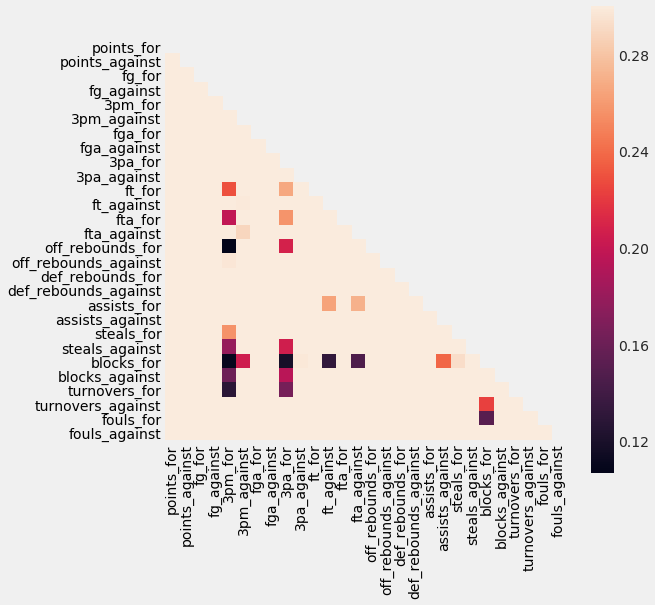

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
corr = stats.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, xticklabels = True, yticklabels = True)

In [45]:
HTML(quant.describe().to_html(classes='table table-responsive table-striped'))

,final_four,season,seed,team_id,points_for,points_against,fg_for,fg_against,3pm_for,3pm_against,fga_for,fga_against,3pa_for,3pa_against,ft_for,ft_against,fta_for,fta_against,off_rebounds_for,off_rebounds_against,def_rebounds_for,def_rebounds_against,assists_for,assists_against,steals_for,steals_against,blocks_for,blocks_against,turnovers_for,turnovers_against,fouls_for,fouls_against
count,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00,1872.00
mean,0.50,2009.95,6.05,1290.26,2370.96,2049.25,836.08,729.79,213.76,192.89,1802.26,1780.15,588.58,585.63,485.04,396.78,686.40,577.32,379.41,351.31,788.69,688.99,469.75,376.67,224.75,193.06,133.78,101.09,403.02,446.56,553.43,605.75
std,0.50,4.34,4.79,99.57,310.72,254.79,115.35,95.10,47.18,35.78,233.19,229.30,116.29,103.06,81.73,74.40,111.37,106.74,73.81,60.89,109.08,94.69,78.42,58.24,49.50,34.69,50.44,23.60,63.21,76.71,79.72,78.79
min,0.00,2003.00,1.00,1102.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,2006.00,2.00,1210.00,2226.00,1957.00,779.00,695.00,184.00,171.00,1708.50,1680.00,525.00,534.00,446.00,357.75,637.00,518.75,337.00,319.00,733.00,646.00,428.00,347.75,191.00,173.00,101.00,87.00,376.00,404.00,522.00,574.00
50%,0.50,2010.00,4.00,1277.00,2403.00,2061.00,838.00,733.00,212.00,192.00,1824.00,1802.00,595.00,588.00,488.00,394.50,698.00,582.00,376.00,355.00,798.00,698.00,467.00,375.00,224.00,194.00,123.00,102.00,398.00,444.00,561.00,615.00
75%,1.00,2014.00,10.00,1386.00,2552.00,2164.00,901.00,776.00,243.00,213.00,1916.00,1903.00,662.00,646.00,525.00,442.00,746.00,641.00,425.00,386.25,851.00,742.00,512.00,406.00,252.00,211.00,159.25,114.00,440.00,493.00,599.00,647.00
max,1.00,2017.00,16.00,1463.00,3016.00,2657.00,1113.00,999.00,342.00,335.00,2245.00,2248.00,923.00,899.00,696.00,648.00,1020.00,921.00,555.00,510.00,1021.00,956.00,709.00,564.00,402.00,291.00,299.00,179.00,584.00,695.00,795.00,795.00


While the team's season statistics are useful, it may be more predictive to understand a team's performance on a per game basis, to understand how it's winning or losing its games.

The main categorical variable is conferences. It appears to also be predictive from the baseline, representing the strength of the conference. Some conferences are generally very strong and play stronger competition than others.
<ul>
<li> big_ten (Michigan State, Purdue, Michigan) </li>
<li> big_twelve (Texas Tech, Kansas State) </li>
<li> acc (Duke, UNC, Virgnia) </li>
</ul>

See that big_east, acc, big_ten, sec, big_twelve all have 5+ teams that have made it to the final four. These are the conferences with the best teams.

In [46]:
HTML(pd.DataFrame(regular_season_total.groupby("conference_code")["final_four"].sum()).sort_values(by="final_four",ascending=False)[0:5].to_html(classes='table table-responsive table-striped'))

,final_four
conference_code,
big_east,11.00
acc,10.00
big_ten,10.00
sec,9.00
big_twelve,6.00


Some other observations include: 
* No seeds greater than 11 have made it to final four
* Teams which make the final four, in the regular season score more, make more FG, give up less FTs, rebound more, block more, foul less, ... all the attributes of a great basketball team

---
# Feature Engineering

## 'Standardize' features

Let's keep the stat metrics on the same scale, on a per game basis rather than standardizing to keep it interpretable. First we need to count the number of games for each team.

In [179]:
regular["game_won"] = np.ones((regular.shape[0], 1))
df_gw = regular.groupby(["season","winning_team_id"]).count().reset_index()[["season", "winning_team_id","game_won"]]
df_gw.columns = ["season", "team_id","game_won"]

In [180]:
regular["game_lost"] = np.ones((regular.shape[0], 1))
df_gl = regular.groupby(["season","losing_team_id"]).count().reset_index()[["season", "losing_team_id","game_lost"]]
df_gl.columns = ["season", "team_id","game_lost"]

In [181]:
df = pd.merge(df,df_gl,how="left",on=['season','team_id'])

In [182]:
df = pd.merge(df,df_gw,how="left",on=['season','team_id'])

In [183]:
df["game_total"] = df["game_won"] + df["game_lost"]
df.fillna(0,inplace=True)

In [184]:
# Effective gf 
# This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
df["efg%"]=(df["fg_for"] + 0.5*df["3pm_for"]) / df["fga_for"]

In [185]:
df.loc[:,'points_for':'fouls_against'] = df[['points_for', 'points_against', 'fg_for', 'fg_against', '3pm_for', '3pm_against',
 'fga_for', 'fga_against', '3pa_for', '3pa_against', 'ft_for',
 'ft_against', 'fta_for', 'fta_against', 'off_rebounds_for',
   'off_rebounds_against', 'def_rebounds_for', 'def_rebounds_against',
   'assists_for', 'assists_against', 'steals_for', 'steals_against',
   'blocks_for', 'blocks_against', 'turnovers_for', 'turnovers_against',
   'fouls_for', 'fouls_against']].apply(lambda x: x / df.game_total)

## Transform and add new features

Let's use some advanced metrics from the NBA. 
Note, opponent % are kept as to gauge defense as well.

In [186]:
# Now, instead of games_won and games_lost, let's combine this into win_%
df['win_%']=df["game_won"]/df["game_total"]

# +/- point differential aka margin of victory
df["margin_of_victory"]=df["points_for"]-df["points_against"]

# Assist to turnover ratio: this measures your ability to care of possessions and pass the ball, as a team.
df["ast_to_ratio"] = df["assists_for"]/df["turnovers_for"]

# Let's convert field goals, threes and fts into %. Will reduce collinearity and also simplify interpretation.
df['fg%_for'] = df['fg_for']/df['fga_for']
df['fg%_against'] = df['fg_against']/df['fga_against']

df['3p%_for'] = X['3pm_for']/X['3pa_for']
df['3p%_against'] = df['3pm_against']/df['3pa_against']

df['ft%_for'] = df['ft_for']/X['fta_for']
df['ft%_against'] = df['ft_against']/df['fta_against']

In [187]:
# drop games won, lost, its redundant with win_%
df = df.drop(["game_won","game_lost"],axis=1) 

In [188]:
# Some games have no data, probably from sampling these teams don't exist. Let's just drop for now since I'm getting NaN.
df.dropna(inplace=True)

In [86]:
df.to_csv("./data/df.csv")
df.shape # 1856 observations

(1856, 77)

I will keep the original features and use regularization methods in the next section.

---
# Modelling
## Logistic Regression with Regularization
### L1: Lasso

I prefer Lasso as a shrinkage method, to narrow down on the most important features, since our baseline model was very accurate already. 

In [201]:
y_test = df[df["season"]>=2015]["final_four"]
y_train = df[df["season"]<2015]["final_four"]
X_train = df.query("season<2015").loc[:,"season":"ft%_against"]
X_test = df.query("season>=2015").loc[:,"season":"ft%_against"]

print(X_train.shape) #80%
print(X_test.shape) #20%

# Instantiate Model
logreg_lasso_1 = LogisticRegression(penalty='l1', C=1)

# Fit model.
logreg_lasso_1.fit(X_train, y_train)

print(f'Logistic Regression Intercept: {logreg_lasso_1.intercept_}')
print(f'Logistic Regression Coefficient: {logreg_lasso_1.coef_}')
print("\n")

# Generate prediction values
print(f'Number of teams making it to final four:{sum(logreg_lasso_1.predict(X_train))}')
print("\n")

# Generate predictions/probabilities
print(logreg_lasso_1.predict_proba(X_train)[:,1])
print("\n")

(1492, 76)
(364, 76)
Logistic Regression Intercept: [0.]
Logistic Regression Coefficient: [[-0.0012153  -0.6837633   0.00072333  0.         -2.44191693  2.48408599
  -0.964152    0.         -0.31075531  0.          0.          0.80899047
  -1.47521544  0.          6.28137961  0.93520549  5.1251736   0.
   0.          0.          0.          0.          1.91588091 -2.56345391
   0.          0.          0.         -2.5507449   0.          0.24535897
   0.          0.          0.          0.          0.          0.
  -3.40287112  0.09635222  0.03212444  0.15745544  0.         -1.68313285
   1.38608677 -0.33650906  0.20264111  0.48025645 -0.49238313  0.19572923
  -0.4448577  -0.24921486  0.67154919  0.40774297 -0.13740773 -0.16521916
   0.01779028 -0.45970706  0.19248742  0.21530272 -0.02207059 -0.01640808
   0.23174252  0.26819881 -0.35574917  0.         -0.47109025  0.24791855
   0.         -2.02168244  0.44660712  0.          0.          0.
   0.          0.          0.          0.     

### Interpretation of Coefficients

In [227]:
lasso_coef = pd.DataFrame(list(zip(X_train.columns,logreg_lasso_1.coef_.T[:,0])))
lasso_coef.columns = ["variable","coef"]
lasso_coef["coef_abs"]=abs(lasso_coef["coef"])
HTML(lasso_coef.sort_values(by="coef_abs",ascending=False)[0:25].to_html(classes='table table-responsive table-striped'))

,variable,coef,coef_abs
14,conference_code_caa,6.28,6.28
16,conference_code_horizon,5.13,5.13
36,conference_code_wcc,-3.40,3.40
23,conference_code_mwc,-2.56,2.56
27,conference_code_pac_twelve,-2.55,2.55
5,conference_code_aac,2.48,2.48
4,conference_code_a_ten,-2.44,2.44
67,win_%,-2.02,2.02
22,conference_code_mvc,1.92,1.92
41,3pm_for,-1.68,1.68


* Outside of conferences, win_% is the most important predictor. Although it's strange to see that it has a negative sign, this is probably the case because schools that make to to the final four actually have lower win % than schools who do not make it to the final four because they face tougher competition (57% avg vs 72% avg). This supports the argument that which conference you play for is very important in predictive power. 

* Again, your strongest conferences, are the big_twelve, acc, big_ten. If you play in acc, your likelihood of reaching final four is very low, because you will likely be dominated by the top tier schools in those conferences. 

* In terms of regular season states, 3PM for and against is important, as the game continues to move shooting more threes, as it's been proven to be an effective strategy. 

* Lastly, seed is not to be overlooked as it's a good composite score for a team's strength, capturing a lot of regular season performance. As your seed increases by 1, your likelihood of reaching final four is 0.50x less. This makes sense, as a 3 seed only has a ~12.5% (0.5^3) of making to final four! This is consistent with FiveThirtyEight's forecasts. Purdue, Houston, & Texas Tech had 10-14% of making it to the Final four.

* Similar to the NBA, margin of victory is a predictive variable though with a positive correlation. In the NBA, there is more parity since each team plays one another at least twice in a season, so individual team stats are more important than seed & conference.

---
## Model Evaluation

In [204]:
# Score the model - accuracy
print(f' Logreg train accuracy: {cross_val_score(logreg_lasso_1, X_train, y_train, cv=5).mean()}')
print("\n")

print(f' Logreg test accuracy: {cross_val_score(logreg_lasso_1, X_test, y_test, cv=5).mean()}')
print("\n")

# Area under the curve
print(f' Area under the curve: {roc_auc_score(y_test, logreg_lasso_1.predict_proba(X_test)[:,1])}')

 Logreg train accuracy: 0.8981365433947868


 Logreg test accuracy: 0.9203453453453454


 Area under the curve: 0.8046269379844961


<table class="table">
<thead class="table-responsive table-striped">
<tr>
<th>Metric</th>
<th>Baseline</th>
<th>Logistic Regression, Lasso = 1</th>
</tr>
<tbody>
<tr>
<td>Train Accuracy</td>
<td>94%</td>
<td>90%</td>
</tr>
<tr>
<td>Test Accuracy</td>
<td>96%</td>
<td>92%</td>
</tr>
<tr>
<td>Area under the curve</td>
<td>77%</td>
<td>80%</td>
</tr>
</tbody>
</table>

Even with fewer variables, this model is arguably as performant as the original.
It does not overfit, and even improves the AUC score by 3%.

In [205]:
# create data frame of true values and predicted probabilities on test set
pred_proba = [i[1] for i in logreg_lasso_1.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

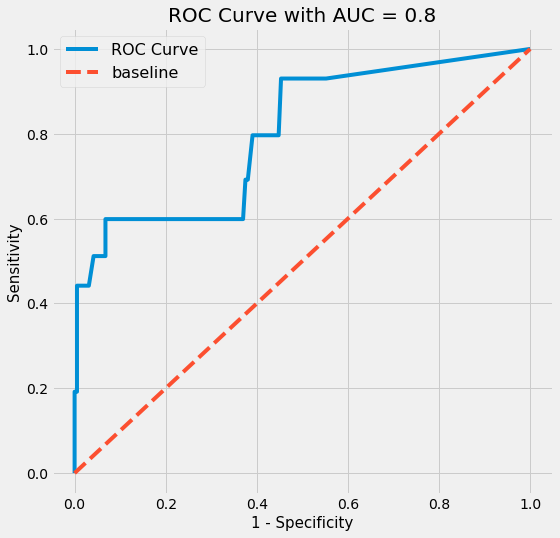

In [206]:
# Create figure.
plt.figure(figsize = (8,8))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),2)}', fontsize=20)
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('1 - Specificity', fontsize=15)

# Create legend.
plt.legend(fontsize=16);

In [229]:
cm = confusion_matrix(y_test, logreg_lasso_1.predict(X_test))
cm_df = pd.DataFrame(data=cm, columns=['predicted negative', 'predicted positive'], index=['actual negative', 'actual positive'])
HTML(cm_df.to_html(classes='table table-responsive table-striped'))

,predicted negative,predicted positive
actual negative,167,25
actual positive,69,103


There are more false negatives than false positives (predicting no final four, when it is final four). The shape of the ROC Curve is due to the random over sampling.

## Hyperparameter Selection 
Let's fine tune our hyperparameter of alpha with GridSearchCV to see if we can improve our model further.

In [208]:
log_params = {
    'penalty':["l1", "l2"],
    'C':list(np.linspace(0.01, 5, 10))
}

log_gridsearch = GridSearchCV(LogisticRegression(random_state=8), log_params, cv=5, verbose=1, n_jobs=2)

log_gridsearch = log_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   36.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.4min finished


In [231]:
print(log_gridsearch.best_score_)
log_gridsearch.best_params_

0.9175603217158177


{'C': 4.445555555555556, 'penalty': 'l1'}

L1 penalty outperforms L2 penalty. Let's gragh the relationship between the strength of C (lambda) and test accuracy.

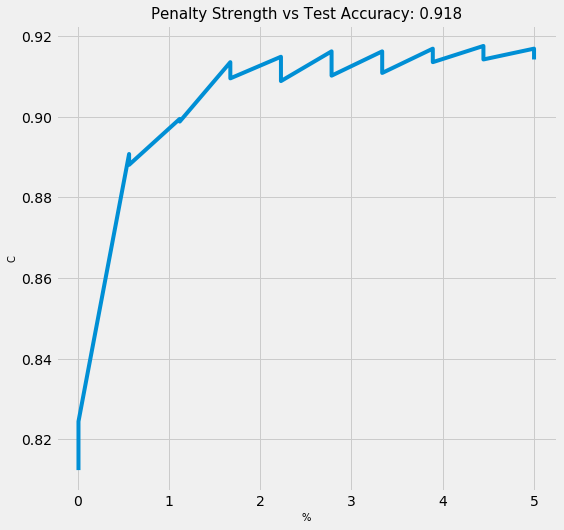

In [234]:
plt.figure(figsize = (8,8))

lst_of_c = [c["C"] for c in pd.DataFrame(log_gridsearch.cv_results_)["params"]]
mean_test_scores = pd.DataFrame(log_gridsearch.cv_results_)["mean_test_score"]
plt.plot(lst_of_c, 
         mean_test_scores)
plt.title(f'Penalty Strength vs Test Accuracy: {round(log_gridsearch.best_score_,3)}', fontsize=15)
plt.ylabel('C', fontsize=10);
plt.xlabel('%', fontsize=10);

In [235]:
print(log_gridsearch.best_score_)
log_gridsearch.best_params_

0.9175603217158177


{'C': 4.445555555555556, 'penalty': 'l1'}

## Best Model

In [210]:
# Instantiate Model
logreg_best = LogisticRegression(penalty='l1', C=log_gridsearch.best_params_["C"])

# Fit model.
logreg_best.fit(X_train, y_train)

# Generate prediction values
yhat_train = logreg_lasso_1.predict(X_train)
yhat_test = logreg_lasso_1.predict(X_test)
print("\n")

# Generate predictions/probabilities
yhat_train_proba = logreg_best.predict_proba(X_train)[:,1]
yhat_test_proba = logreg_best.predict_proba(X_test)[:,1]

# Score the model - accuracy
print(f' Logreg train accuracy: {cross_val_score(logreg_best, X_train, y_train, cv=5).mean()}')
print("\n")

print(f' Logreg test accuracy: {cross_val_score(logreg_best, X_test, y_test, cv=5).mean()}')
print("\n")

# Area under the curve
print(f' Area under the curve: {roc_auc_score(y_test, logreg_best.predict_proba(X_test)[:,1])}')



 Logreg train accuracy: 0.9168948657714342


 Logreg test accuracy: 0.9341591591591591


 Area under the curve: 0.786125242248062


<table class="table">
<thead class="table-responsive table-striped">
<tr>
<th>Metric</th>
<th>Baseline</th>
<th>Logistic Regression, Lasso = 1</th>
<th>Logistic Regression, Lasso = Optimal</th>
</tr>
<tbody>
<tr>
<td>Train Accuracy</td>
<td>94%</td>
<td>90%</td>
<td>92%</td>
</tr>
<tr>
<td>Test Accuracy</td>
<td>96%</td>
<td>92%</td>
<td>93%</td>
</tr>
<tr>
<td>Area under the curve</td>
<td>77%</td>
<td>80%</td>
<td>79%</td>
</tr>
</tbody>
</table>

In [211]:
pred_15_17 = pd.DataFrame(zip(X_test[["season","team_id"]],yhat_test))
pred_15_17 = pd.DataFrame(
    {"season": X_test["season"],
     "team_id": X_test["team_id"],
     "final_four": y_test,
     "yhat": yhat_test  
    }
)

In [230]:
results = pd.merge(pred_15_17,teams, how="left",on=["season","team_id"]).drop_duplicates().reset_index()
results.sort_values(by="final_four",ascending=False).drop("index",axis=1)
HTML(results.query('final_four==1').to_html(classes='table table-striped table-responsive'))

,index,season,team_id,final_four,yhat,team_name,conference_code
6,155,2015.00,1277.00,1.00,0.00,Michigan St,big_ten
17,421,2015.00,1181.00,1.00,1.00,Duke,acc
50,1077,2015.00,1458.00,1.00,1.00,Wisconsin,big_ten
67,1440,2016.00,1314.00,1.00,1.00,North Carolina,acc
94,2048,2016.00,1393.00,1.00,0.00,Syracuse,acc
102,2204,2016.00,1437.00,1.00,1.00,Villanova,big_east
119,2498,2016.00,1328.00,1.00,0.00,Oklahoma,big_twelve
141,2997,2017.00,1376.00,1.00,0.00,South Carolina,sec
153,3244,2017.00,1211.00,1.00,1.00,Gonzaga,wcc
171,3556,2017.00,1332.00,1.00,0.00,Oregon,pac_twelve


---
# Results 

Overall, I was able to improve from the baseline logistic model by and 2% in ROC curve. What I am impressed about is that the best model via Lasso is able to predict with less variables, while also maintaining interpretability (no wild transformations), with almost the same level of accuracy for test.

In summary:

* Win_% is the most important predictor. Although it's strange to see that it has a negative sign, this is probably the case because schools that make to to the final four actually have lower win % than schools who do not make it to the final four because they face tougher competition (57% avg vs 72% avg). This supports the argument that which conference you play for is very important in predictive power. 

* Again, your strongest conferences, are the big_twelve, acc, big_ten. If you play in acc, your likelihood of reaching final four is very low, because you will likely be dominated by the top tier schools in those conferences. 

* In terms of regular season states, 3PM for and against is important, as the game continues to move shooting more threes, as it's been proven to be an effective strategy. 

* Lastly, seed is not to be overlooked as it's a good composite score for a team's strength, capturing a lot of regular season performance. As your seed increases by 1, your likelihood of reaching final four is 0.5x less. This makes sense... a 3 seed only has a ~12.5% (0.5^3) of making to final four! This is consistent with FiveThirtyEight's forecasts. Purdue, Houston, & Texas Tech had 10-14% of making it to the Final four.

* Similar to the NBA, margin of victory is a predictive variable though with a positive correlation. In the NBA, there is more parity since each team plays one another at least twice in a season, so individual team stats are more important than seed & conference.

My model predicts the probability of a team reaching the final four, primarily based on its regular season data, seed, and conference. I would recommend coaches to develop the three ball ability, as it continues dominate in the NBA and at the college level, and to outperform in the regular season to improve your seeding, to ultimately improve your chances in moving to the final four, through playing weaker opponents. 

Assumptions 
<ul>
<li> In this model, there are things that we cannot predict, including injuries, player specific data, draft prospects, travel & time between games (are players are well rested?), coaches track record, momentum of a team firing on all cylinders (last 10 games), given the absence of data. </li>

<li> In this example, there isn't a penalty on false positives vs false negatives, as wrong is wrong. Predicting a loser who won isn't worse than a winner that lost. There may be implications in gambling, but that's out of scope.  </li>

Research Links
<li> https://projects.fivethirtyeight.com/2019-march-madness-predictions/ </li>
</ul>

---

##  Next Steps

This was a very fun exploration and may plan to revisit this project in a future blog post.

Ideas:
<ul>
    <li> Simulating winner between 2 games (or at the very least, the final four), using a Poisson model for pts scored </li>
    <li> Logistic vs Non Parametric (KNN, SVM, random forests) </li>
    <li> Scrap 2018 data, and run model, and add graphs (with SMOTE, 2015->2017 data is obfuscated) </li>
    <li> Feature engineer strength of schedule (they have this on sports reference) </li>
    <li> ELO </li>
    <li> No. of previous appearances in history </li>
    <li> Confidence intervals of predicted probabilities </li>
</ul>